## 1. Setup & Import Libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os
import sys

# Configure
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Add src to path - use absolute path for reliability
NOTEBOOK_DIR = Path(os.path.abspath('')).resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
SRC_DIR = PROJECT_ROOT / 'src'
sys.path.insert(0, str(SRC_DIR))

print(f"Project root: {PROJECT_ROOT}")
print(f"Source dir: {SRC_DIR}")
print(f"Source dir exists: {SRC_DIR.exists()}")

# Import custom modules
from mining import (
    # Association Rules
    prepare_transactions,
    run_apriori,
    run_fpgrowth,
    extract_rules,
    filter_rules_by_consequent,
    get_top_rules,
    summarize_rules,
    plot_rules_heatmap,
    plot_support_confidence_scatter,
    mine_association_rules,
    MLXTEND_AVAILABLE,
    
    # Clustering
    prepare_clustering_data,
    find_optimal_k,
    plot_elbow_silhouette,
    run_kmeans,
    run_dbscan,
    run_hierarchical,
    evaluate_clustering,
    profile_clusters,
    identify_high_risk_clusters,
    plot_clusters_2d,
    plot_cluster_profiles,
    plot_cancellation_by_cluster,
    cluster_bookings
)

print("✅ Libraries imported successfully!")
print(f"   mlxtend available: {MLXTEND_AVAILABLE}")

Project root: C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining
Source dir: C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\src
Source dir exists: True


✅ Libraries imported successfully!
   mlxtend available: True


## 2. Load Data

In [2]:
# Paths
DATA_RAW = Path.cwd().parent / 'data' / 'raw' / 'hotel_bookings.csv'
DATA_PROCESSED = Path.cwd().parent / 'data' / 'processed'
OUTPUT_DIR = Path.cwd().parent / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures'
TABLES_DIR = OUTPUT_DIR / 'tables'

# Create output directories if not exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# Load raw data for association rules (need original categorical values)
df_raw = pd.read_csv(DATA_RAW)
print(f"Raw data shape: {df_raw.shape}")

# Load cleaned data if available
train_path = DATA_PROCESSED / 'X_train.csv'
if train_path.exists():
    X_train = pd.read_csv(train_path)
    y_train = pd.read_csv(DATA_PROCESSED / 'y_train.csv')['is_canceled']
    print(f"Processed train data shape: {X_train.shape}")
else:
    print("⚠️ Processed data not found. Will use raw data.")
    X_train = None

Raw data shape: (119390, 32)
⚠️ Processed data not found. Will use raw data.


In [3]:
# Quick look at data
df_raw.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


---

# PART A: ASSOCIATION RULES MINING

---

## 3. Data Preparation for Association Rules

Association rules yêu cầu dữ liệu dạng transaction (binary/categorical). Ta sẽ:
1. Chọn các cột categorical quan trọng
2. Bin các cột numerical thành các nhóm
3. Chuyển đổi sang dạng one-hot encoding

In [4]:
# Prepare data for association rules
# Drop leakage columns first
df_for_ar = df_raw.drop(columns=['reservation_status', 'reservation_status_date'], errors='ignore').copy()

# Remove rows with missing agent (or fill with 'Unknown')
df_for_ar = df_for_ar.dropna(subset=['country'])

print(f"Data shape after dropping leakage: {df_for_ar.shape}")

Data shape after dropping leakage: (118902, 30)


In [5]:
# Define columns for association rules
categorical_cols = [
    'hotel',
    'is_canceled',
    'meal',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'deposit_type',
    'customer_type'
]

# Columns to bin
numerical_cols_to_bin = {
    'lead_time': [0, 7, 30, 90, 180, float('inf')],
    'adr': [0, 50, 100, 150, 200, float('inf')],
    'total_of_special_requests': [0, 1, 2, float('inf')]
}

bin_labels = {
    'lead_time': ['0-7d', '7-30d', '30-90d', '90-180d', '180d+'],
    'adr': ['0-50', '50-100', '100-150', '150-200', '200+'],
    'total_of_special_requests': ['0_req', '1_req', '2+_req']
}

In [6]:
# Create binned columns
df_ar = df_for_ar[categorical_cols].copy()

for col, bins in numerical_cols_to_bin.items():
    df_ar[col] = pd.cut(
        df_for_ar[col], 
        bins=bins, 
        labels=bin_labels[col],
        include_lowest=True
    )

# Convert is_canceled to string for better readability
df_ar['is_canceled'] = df_ar['is_canceled'].map({0: 'NotCanceled', 1: 'Canceled'})
df_ar['is_repeated_guest'] = df_ar['is_repeated_guest'].map({0: 'NewGuest', 1: 'RepeatedGuest'})

print(f"Data for Association Rules: {df_ar.shape}")
df_ar.head()

Data for Association Rules: (118902, 11)


,hotel,is_canceled,meal,market_segment,distribution_channel,is_repeated_guest,deposit_type,customer_type,lead_time,adr,total_of_special_requests
0,Resort Hotel,NotCanceled,BB,Direct,Direct,NewGuest,No Deposit,Transient,180d+,0-50,0_req
1,Resort Hotel,NotCanceled,BB,Direct,Direct,NewGuest,No Deposit,Transient,180d+,0-50,0_req
2,Resort Hotel,NotCanceled,BB,Direct,Direct,NewGuest,No Deposit,Transient,0-7d,50-100,0_req
3,Resort Hotel,NotCanceled,BB,Corporate,Corporate,NewGuest,No Deposit,Transient,7-30d,50-100,0_req
4,Resort Hotel,NotCanceled,BB,Online TA,TA/TO,NewGuest,No Deposit,Transient,7-30d,50-100,0_req


In [7]:
# Check for missing values
df_ar.isnull().sum()

hotel                        0
is_canceled                  0
meal                         0
market_segment               0
distribution_channel         0
is_repeated_guest            0
deposit_type                 0
customer_type                0
lead_time                    0
adr                          1
total_of_special_requests    0
dtype: int64

In [8]:
# Drop rows with any missing values
df_ar = df_ar.dropna()
print(f"Data shape after dropping NA: {df_ar.shape}")

Data shape after dropping NA: (118901, 11)


## 4. Prepare Transaction Data

In [9]:
# Prepare transactions using our module
# The function will one-hot encode all categorical columns
df_encoded = prepare_transactions(
    df_ar,
    columns=df_ar.columns.tolist(),
    include_target=False,  # is_canceled already in df_ar
    verbose=True
)

PREPARING DATA FOR ASSOCIATION RULES
Input shape: (118901, 11)
Selected columns: ['hotel', 'is_canceled', 'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'deposit_type', 'customer_type', 'lead_time', 'adr', 'total_of_special_requests']
Output shape: (118901, 44)
Number of items: 44


In [10]:
# View encoded data
print(f"Encoded shape: {df_encoded.shape}")
print(f"\nAll column names:")
print(df_encoded.columns.tolist())

# Find cancellation columns
cancel_cols = [c for c in df_encoded.columns if 'cancel' in c.lower()]
print(f"\nCancellation-related columns: {cancel_cols}")

Encoded shape: (118901, 44)

All column names:
['hotel=City Hotel', 'hotel=Resort Hotel', 'is_canceled=Canceled', 'is_canceled=NotCanceled', 'meal=BB', 'meal=FB', 'meal=HB', 'meal=SC', 'meal=Undefined', 'market_segment=Aviation', 'market_segment=Complementary', 'market_segment=Corporate', 'market_segment=Direct', 'market_segment=Groups', 'market_segment=Offline TA/TO', 'market_segment=Online TA', 'market_segment=Undefined', 'distribution_channel=Corporate', 'distribution_channel=Direct', 'distribution_channel=GDS', 'distribution_channel=TA/TO', 'distribution_channel=Undefined', 'is_repeated_guest=NewGuest', 'is_repeated_guest=RepeatedGuest', 'deposit_type=No Deposit', 'deposit_type=Non Refund', 'deposit_type=Refundable', 'customer_type=Contract', 'customer_type=Group', 'customer_type=Transient', 'customer_type=Transient-Party', 'lead_time=0-7d', 'lead_time=7-30d', 'lead_time=30-90d', 'lead_time=90-180d', 'lead_time=180d+', 'adr=0-50', 'adr=50-100', 'adr=100-150', 'adr=150-200', 'adr=20

## 5. Run Association Rules Mining

In [11]:
if MLXTEND_AVAILABLE:
    # Run Apriori algorithm
    frequent_itemsets = run_apriori(
        df_encoded,
        min_support=0.05,  # Items appearing in at least 5% of transactions
        verbose=True
    )
else:
    print("⚠️ mlxtend not available. Please install: pip install mlxtend")

RUNNING APRIORI ALGORITHM
Min support: 0.05
Max itemset length: None


Found 6925 frequent itemsets
Support range: [0.0500, 0.9680]


In [12]:
if MLXTEND_AVAILABLE and frequent_itemsets is not None:
    # Extract association rules
    rules = extract_rules(
        frequent_itemsets,
        metric='confidence',
        min_threshold=0.5,  # Rules with confidence >= 50%
        verbose=True
    )
    
    if rules is not None and len(rules) > 0:
        print(f"\n📊 Total rules extracted: {len(rules)}")

EXTRACTING ASSOCIATION RULES
Metric: confidence
Min threshold: 0.5


Found 95411 rules
Lift range: [0.57, 9.19]
Confidence range: [0.50, 1.00]

📊 Total rules extracted: 95411


## 6. Analyze Rules for Cancellation

In [13]:
# Find the exact column name for canceled
cancel_col_name = [c for c in df_encoded.columns if 'Canceled' in c and 'Not' not in c]
print(f"Looking for column containing 'Canceled': {cancel_col_name}")

if MLXTEND_AVAILABLE and 'rules' in dir() and rules is not None and len(rules) > 0:
    # Filter rules that predict cancellation
    # Use the actual column name from the encoded data
    if cancel_col_name:
        cancel_rules = filter_rules_by_consequent(
            rules,
            consequent_items=cancel_col_name
        )
    else:
        # Try different naming patterns
        cancel_rules = filter_rules_by_consequent(
            rules,
            consequent_items=['is_canceled=Canceled', 'canceled=Canceled', 'is_canceled_Canceled']
        )
    
    if cancel_rules is not None and len(cancel_rules) > 0:
        print(f"🎯 Rules predicting CANCELLATION: {len(cancel_rules)}")
    else:
        print("⚠️ No cancellation rules found - trying to list available consequents:")
        # Show unique consequents to debug
        unique_consequents = set()
        for _, r in rules.iterrows():
            for item in r['consequents']:
                unique_consequents.add(item)
        print(f"Available consequents: {sorted(unique_consequents)[:20]}")
        cancel_rules = None
else:
    print("⚠️ No rules available to filter")
    cancel_rules = None

Looking for column containing 'Canceled': ['is_canceled=Canceled']
🎯 Rules predicting CANCELLATION: 5749


In [14]:
if MLXTEND_AVAILABLE and 'cancel_rules' in dir() and cancel_rules is not None and len(cancel_rules) > 0:
    # Get top rules by lift (no verbose parameter)
    top_cancel_rules = get_top_rules(
        cancel_rules,
        n=15,
        sort_by='lift'
    )
    print(f"📊 Top 15 cancellation rules:")
    print(top_cancel_rules)
else:
    print("⚠️ No cancellation rules found")

📊 Top 15 cancellation rules:
                                                 rule   support  confidence  \
0   deposit_type=Non Refund, meal=BB, distribution...  0.050269    0.511905   
1   deposit_type=Non Refund, is_repeated_guest=New...  0.050269    0.511949   
2   deposit_type=Non Refund, meal=BB, distribution...  0.050269    0.511905   
3   deposit_type=Non Refund, meal=BB, distribution...  0.050269    0.509852   
4   deposit_type=Non Refund, meal=BB, distribution...  0.050269    0.509852   
5   deposit_type=Non Refund, meal=BB, distribution...  0.050269    0.509896   
6   deposit_type=Non Refund, meal=BB, distribution...  0.050269    0.509896   
7   deposit_type=Non Refund, meal=BB, distribution...  0.050269    0.509852   
8   deposit_type=Non Refund, meal=BB, distribution...  0.050269    0.509852   
9   hotel=City Hotel, market_segment=Groups, custo...  0.050269    0.878067   
10  market_segment=Groups, customer_type=Transient...  0.050269    0.877422   
11  market_segment=Grou

In [15]:
if MLXTEND_AVAILABLE and 'cancel_rules' in dir() and cancel_rules is not None and len(cancel_rules) > 0:
    # Display top rules nicely
    print("\n" + "="*80)
    print("🔥 TOP 10 RULES PREDICTING CANCELLATION (by Lift)")
    print("="*80)
    
    for i, (_, rule) in enumerate(cancel_rules.nlargest(10, 'lift').iterrows(), 1):
        antecedent = ', '.join(list(rule['antecedents']))
        consequent = ', '.join(list(rule['consequents']))
        
        print(f"\nRule {i}:")
        print(f"  IF: {antecedent}")
        print(f"  THEN: {consequent}")
        print(f"  Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")


🔥 TOP 10 RULES PREDICTING CANCELLATION (by Lift)

Rule 1:
  IF: deposit_type=Non Refund, meal=BB, distribution_channel=TA/TO, is_repeated_guest=NewGuest
  THEN: total_of_special_requests=0_req, market_segment=Groups, customer_type=Transient, hotel=City Hotel, is_canceled=Canceled
  Support: 0.050, Confidence: 0.512, Lift: 9.191

Rule 2:
  IF: deposit_type=Non Refund, is_repeated_guest=NewGuest, total_of_special_requests=0_req, meal=BB, distribution_channel=TA/TO
  THEN: is_canceled=Canceled, market_segment=Groups, customer_type=Transient, hotel=City Hotel
  Support: 0.050, Confidence: 0.512, Lift: 9.191

Rule 3:
  IF: deposit_type=Non Refund, meal=BB, distribution_channel=TA/TO, is_repeated_guest=NewGuest
  THEN: is_canceled=Canceled, market_segment=Groups, customer_type=Transient, hotel=City Hotel
  Support: 0.050, Confidence: 0.512, Lift: 9.190

Rule 4:
  IF: deposit_type=Non Refund, meal=BB, distribution_channel=TA/TO
  THEN: is_repeated_guest=NewGuest, total_of_special_requests=0_

## 7. Rules for Non-Cancellation

In [16]:
if MLXTEND_AVAILABLE and 'rules' in dir() and rules is not None and len(rules) > 0:
    # Filter rules that predict NOT cancellation
    not_cancel_rules = filter_rules_by_consequent(
        rules,
        consequent_items=['is_canceled=NotCanceled']
    )
    
    if not_cancel_rules is not None and len(not_cancel_rules) > 0:
        print(f"✅ Rules predicting NOT CANCELED: {len(not_cancel_rules)}")
        
        # Top rules
        print("\n" + "="*80)
        print("🔥 TOP 10 RULES PREDICTING NOT CANCELED (by Lift)")
        print("="*80)
        
        for i, (_, rule) in enumerate(not_cancel_rules.nlargest(10, 'lift').iterrows(), 1):
            antecedent = ', '.join(list(rule['antecedents']))
            consequent = ', '.join(list(rule['consequents']))
            
            print(f"\nRule {i}:")
            print(f"  IF: {antecedent}")
            print(f"  THEN: {consequent}")
            print(f"  Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")

✅ Rules predicting NOT CANCELED: 10210

🔥 TOP 10 RULES PREDICTING NOT CANCELED (by Lift)

Rule 1:
  IF: deposit_type=No Deposit, market_segment=Direct, total_of_special_requests=0_req
  THEN: distribution_channel=Direct, is_canceled=NotCanceled, is_repeated_guest=NewGuest, customer_type=Transient, meal=BB
  Support: 0.054, Confidence: 0.605, Lift: 9.064

Rule 2:
  IF: distribution_channel=Direct, deposit_type=No Deposit, is_repeated_guest=NewGuest, customer_type=Transient, meal=BB
  THEN: market_segment=Direct, is_canceled=NotCanceled, total_of_special_requests=0_req
  Support: 0.054, Confidence: 0.683, Lift: 9.057

Rule 3:
  IF: market_segment=Direct, total_of_special_requests=0_req
  THEN: distribution_channel=Direct, is_canceled=NotCanceled, deposit_type=No Deposit, is_repeated_guest=NewGuest, customer_type=Transient, meal=BB
  Support: 0.054, Confidence: 0.604, Lift: 9.043

Rule 4:
  IF: market_segment=Direct, total_of_special_requests=0_req
  THEN: distribution_channel=Direct, is_

## 8. Visualize Association Rules

✓ Saved figure to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\association_rules_scatter.png


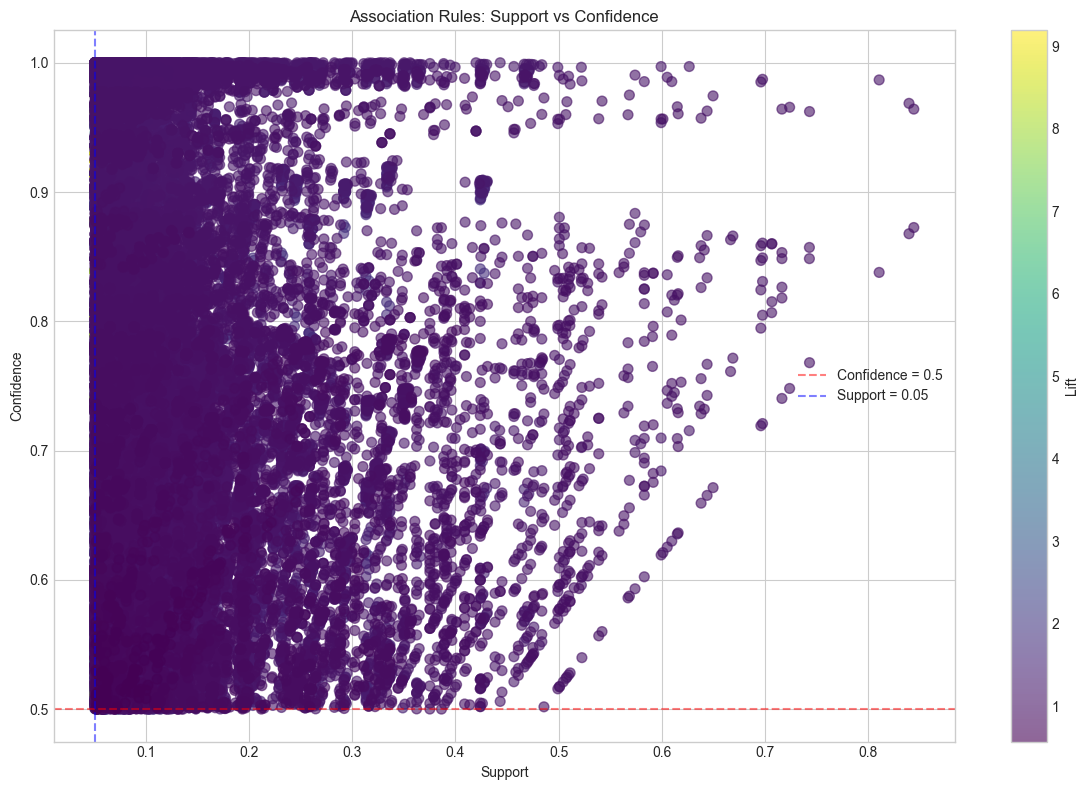

In [17]:
if MLXTEND_AVAILABLE and 'rules' in dir() and rules is not None and len(rules) > 0:
    # Support-Confidence scatter plot
    plot_support_confidence_scatter(
        rules,
        figsize=(12, 8),
        save_path=str(FIGURES_DIR / 'association_rules_scatter.png')
    )

✓ Saved figure to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\cancellation_rules_heatmap.png


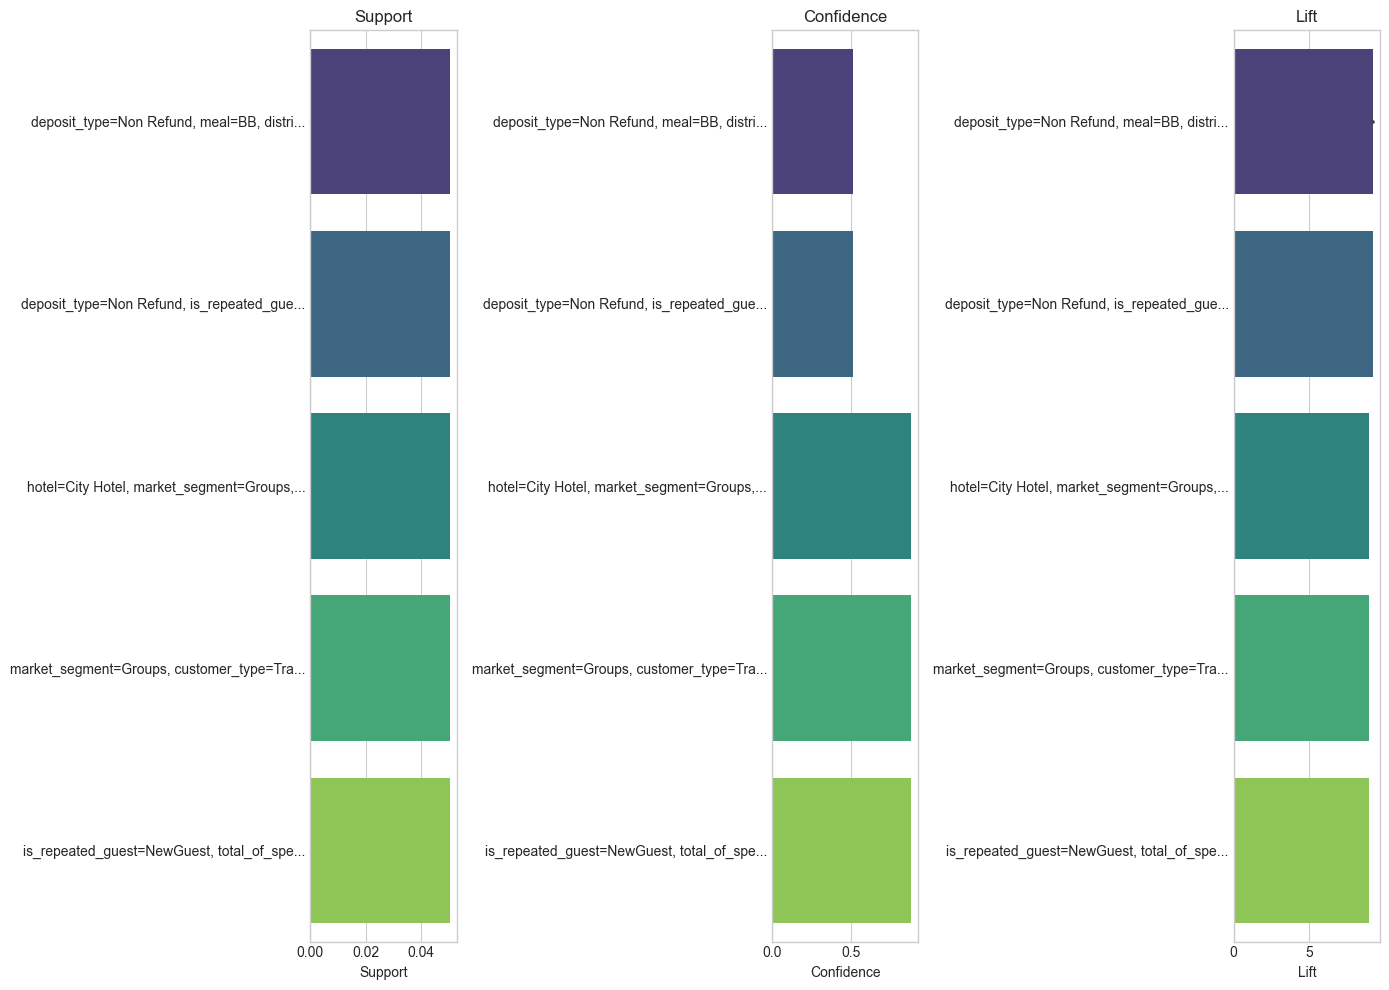

In [18]:
if MLXTEND_AVAILABLE and 'cancel_rules' in dir() and cancel_rules is not None and len(cancel_rules) >= 5:
    # Heatmap for cancellation rules
    plot_rules_heatmap(
        cancel_rules.head(15),
        figsize=(14, 10),
        save_path=str(FIGURES_DIR / 'cancellation_rules_heatmap.png')
    )

## 9. Summary of Association Rules

In [19]:
if MLXTEND_AVAILABLE and 'rules' in dir() and rules is not None and len(rules) > 0:
    # Summary statistics (no verbose parameter)
    summary = summarize_rules(rules, name="All Rules")
    print("📊 Association Rules Summary:")
    print(summary.to_string(index=False))

📊 Association Rules Summary:
     Name  Total Rules  Avg Support  Avg Confidence  Avg Lift  Max Lift  Rules with Lift > 1
All Rules        95411     0.093988        0.733707  1.632636  9.191481                79193


In [20]:
# Save rules to file
if MLXTEND_AVAILABLE and 'cancel_rules' in dir() and cancel_rules is not None and len(cancel_rules) > 0:
    # Convert frozensets to strings for saving
    rules_to_save = cancel_rules.copy()
    rules_to_save['antecedents'] = rules_to_save['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_to_save['consequents'] = rules_to_save['consequents'].apply(lambda x: ', '.join(list(x)))
    
    rules_to_save.to_csv(TABLES_DIR / 'association_rules_cancellation.csv', index=False)
    print(f"✅ Saved cancellation rules to {TABLES_DIR / 'association_rules_cancellation.csv'}")

✅ Saved cancellation rules to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\tables\association_rules_cancellation.csv


---

# PART B: CUSTOMER CLUSTERING

---

## 10. Prepare Data for Clustering

In [21]:
# Use raw data for clustering (to have access to target for profiling)
# Clean the data first
df_cluster = df_raw.drop(columns=['reservation_status', 'reservation_status_date'], errors='ignore').copy()

# Handle missing values for clustering features
df_cluster['children'] = df_cluster['children'].fillna(0)
df_cluster['agent'] = df_cluster['agent'].fillna(0)
df_cluster['company'] = df_cluster['company'].fillna(0)

# Create derived features if not exist
if 'total_nights' not in df_cluster.columns:
    df_cluster['total_nights'] = df_cluster['stays_in_weekend_nights'] + df_cluster['stays_in_week_nights']
    
if 'total_guests' not in df_cluster.columns:
    df_cluster['total_guests'] = df_cluster['adults'] + df_cluster['children'] + df_cluster['babies']

print(f"Data for clustering: {df_cluster.shape}")

Data for clustering: (119390, 32)


In [22]:
# Define clustering features
clustering_features = [
    'lead_time',
    'total_nights',
    'total_guests',
    'adr',
    'total_of_special_requests',
    'booking_changes',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'days_in_waiting_list',
    'is_repeated_guest'
]

# Verify features exist
available_features = [f for f in clustering_features if f in df_cluster.columns]
print(f"Available clustering features: {available_features}")

Available clustering features: ['lead_time', 'total_nights', 'total_guests', 'adr', 'total_of_special_requests', 'booking_changes', 'previous_cancellations', 'previous_bookings_not_canceled', 'days_in_waiting_list', 'is_repeated_guest']


In [23]:
# Prepare clustering data using our module
X_scaled, scaler, feature_names = prepare_clustering_data(
    df_cluster,
    features=available_features,
    scaling_method='standard',
    verbose=True
)

PREPARING DATA FOR CLUSTERING
Selected features: ['lead_time', 'total_nights', 'total_guests', 'adr', 'total_of_special_requests', 'booking_changes', 'previous_cancellations', 'previous_bookings_not_canceled', 'days_in_waiting_list', 'is_repeated_guest']
Data shape: (119390, 10)
Missing values after handling: 0
Scaling method: standard


## 11. Find Optimal Number of Clusters

In [24]:
# Sample data for faster computation (clustering can be slow on large data)
SAMPLE_SIZE = 20000

if len(X_scaled) > SAMPLE_SIZE:
    np.random.seed(42)
    sample_idx = np.random.choice(len(X_scaled), SAMPLE_SIZE, replace=False)
    X_sample = X_scaled.iloc[sample_idx]
    df_sample = df_cluster.iloc[sample_idx]
    print(f"Using sample of {SAMPLE_SIZE} rows for faster computation")
else:
    X_sample = X_scaled
    df_sample = df_cluster
    print(f"Using full data: {len(X_sample)} rows")

Using sample of 20000 rows for faster computation


In [25]:
# Find optimal k
optimal_k_results = find_optimal_k(
    X_sample,
    k_range=(2, 11),
    verbose=True
)

FINDING OPTIMAL NUMBER OF CLUSTERS
Testing k from 2 to 10


  k=2: Inertia=174566, Silhouette=0.5952


  k=3: Inertia=156402, Silhouette=0.1984


  k=4: Inertia=142832, Silhouette=0.2153


  k=5: Inertia=128647, Silhouette=0.2035


  k=6: Inertia=118274, Silhouette=0.2100


  k=7: Inertia=109087, Silhouette=0.2139


  k=8: Inertia=95111, Silhouette=0.2161


  k=9: Inertia=87439, Silhouette=0.2167


  k=10: Inertia=80205, Silhouette=0.2306
------------------------------------------------------------
Optimal k (Silhouette): 2 (score: 0.5952)
Optimal k (Elbow): 8


✓ Saved figure to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\clustering_optimal_k.png


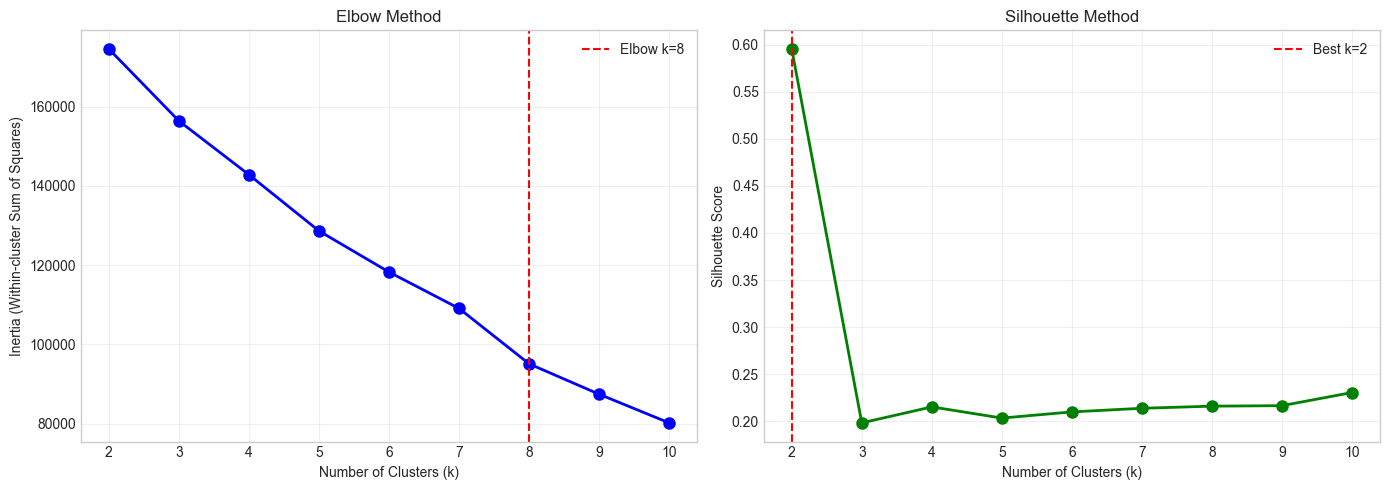

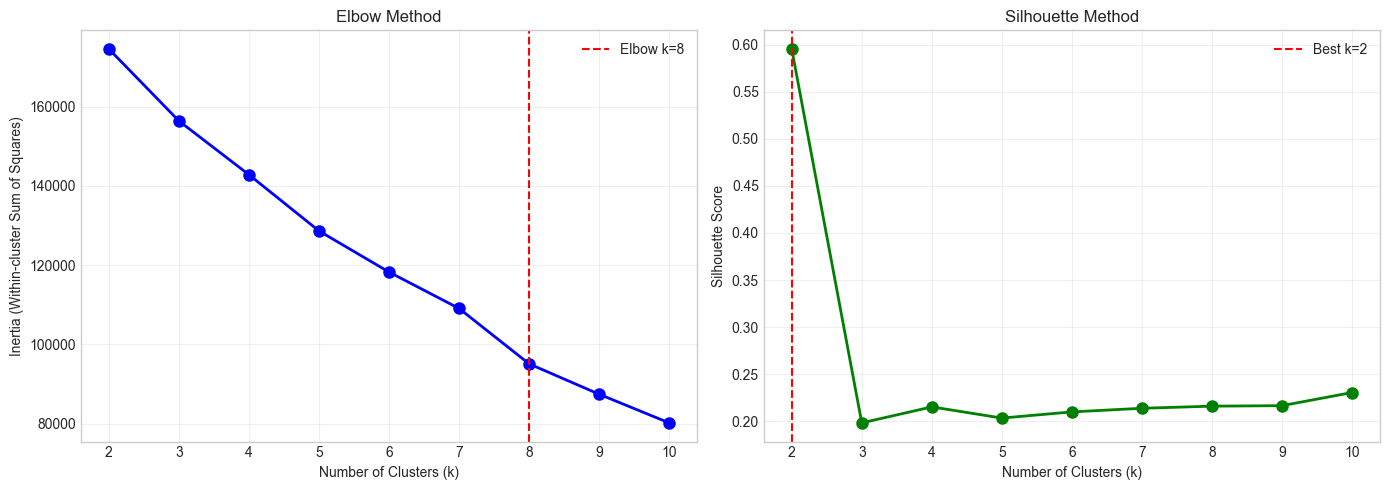

In [26]:
# Plot elbow and silhouette
plot_elbow_silhouette(
    optimal_k_results,
    figsize=(14, 5),
    save_path=str(FIGURES_DIR / 'clustering_optimal_k.png')
)

## 12. Run KMeans Clustering

In [27]:
# Use optimal k from silhouette method (or choose manually)
optimal_k = optimal_k_results['optimal_k_silhouette']
print(f"Using k = {optimal_k}")

# Run KMeans
labels_kmeans, kmeans_model = run_kmeans(
    X_sample,
    n_clusters=optimal_k,
    verbose=True
)

Using k = 2
RUNNING KMEANS (k=2)
Inertia: 174566.41
Iterations: 3

Cluster sizes:
  Cluster 0: 19,330 (96.7%)
  Cluster 1: 670 (3.4%)


In [28]:
# Evaluate clustering
metrics_kmeans = evaluate_clustering(X_sample, labels_kmeans, verbose=True)

CLUSTERING EVALUATION METRICS
Number of clusters: 2
Silhouette Score: 0.5952 (higher is better, -1 to 1)
Davies-Bouldin Index: 0.9924 (lower is better)
Calinski-Harabasz Index: 3059.26 (higher is better)


✓ Saved figure to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\kmeans_clusters_pca.png


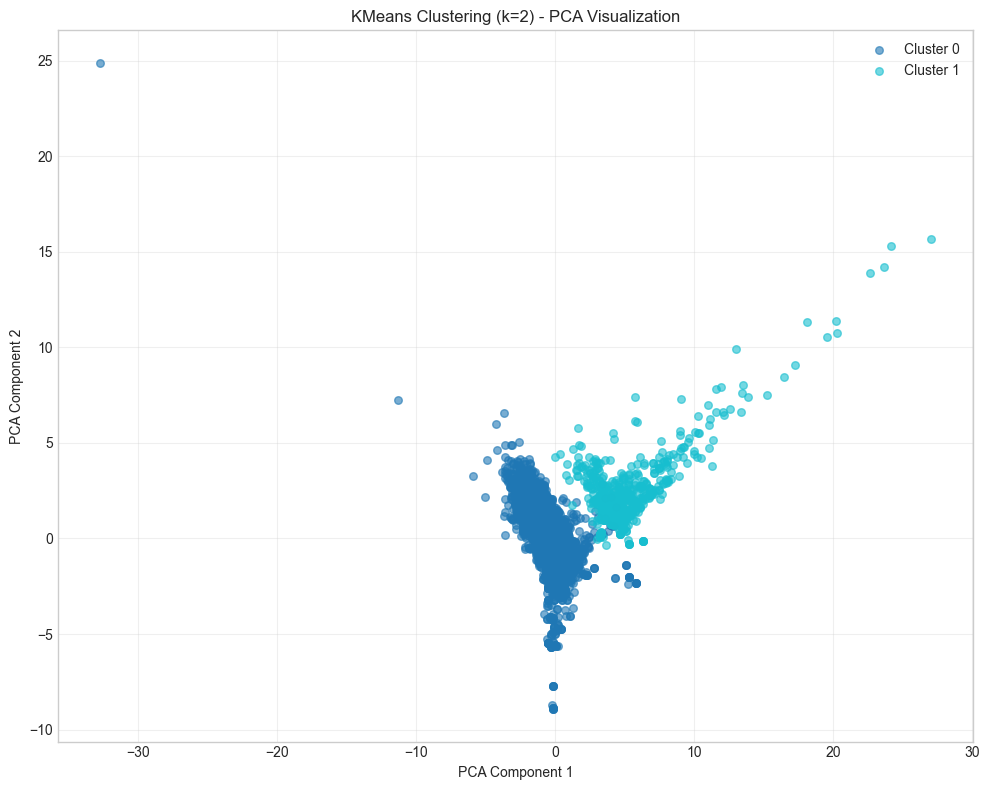

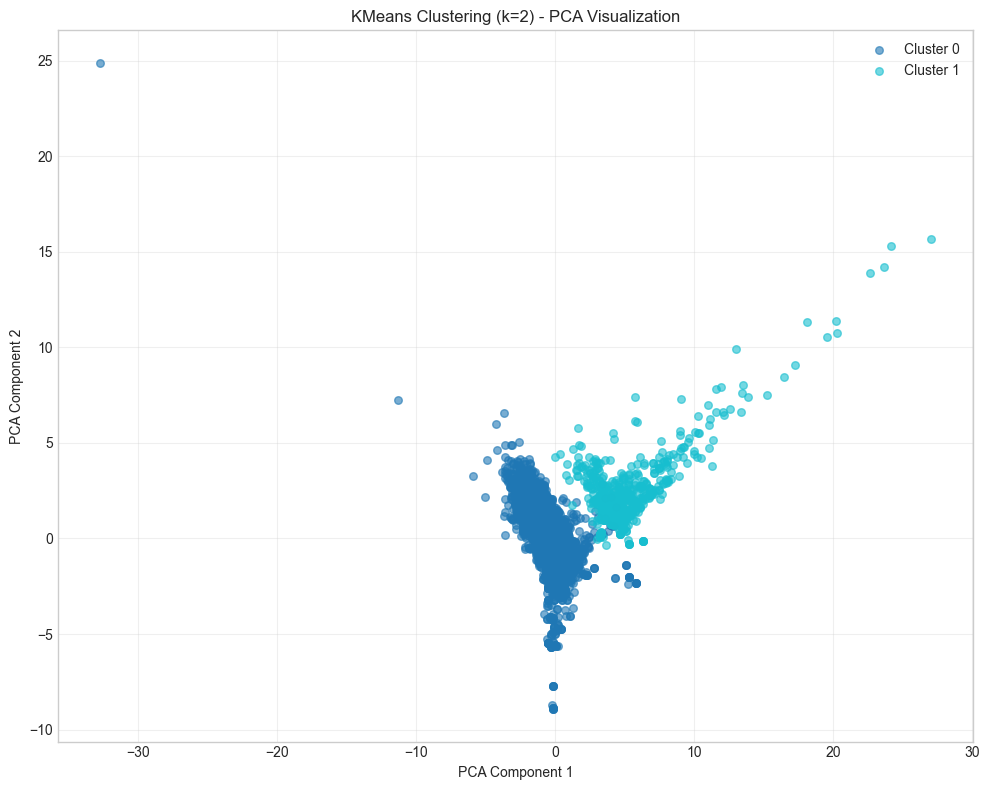

In [29]:
# Visualize clusters with PCA
plot_clusters_2d(
    X_sample,
    labels_kmeans,
    method='pca',
    title=f'KMeans Clustering (k={optimal_k}) - PCA Visualization',
    figsize=(10, 8),
    save_path=str(FIGURES_DIR / 'kmeans_clusters_pca.png')
)

## 13. Profile Clusters

In [30]:
# Profile clusters
profiles_kmeans = profile_clusters(
    df_sample,
    labels_kmeans,
    features=feature_names,
    target_col='is_canceled',
    verbose=True
)

CLUSTER PROFILING

Cluster Summary:

📊 Cluster 0:
   Size: 19,330 (96.7%)
   Cancellation Rate: 38.5%

📊 Cluster 1:
   Size: 670 (3.4%)
   Cancellation Rate: 14.8%


In [31]:
# Identify high-risk clusters
high_risk_clusters = identify_high_risk_clusters(
    profiles_kmeans,
    threshold_pct=50.0,
    verbose=True
)


🚨 High-risk clusters (cancel rate >= 50.0%):


✓ Saved figure to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\kmeans_cancellation_by_cluster.png


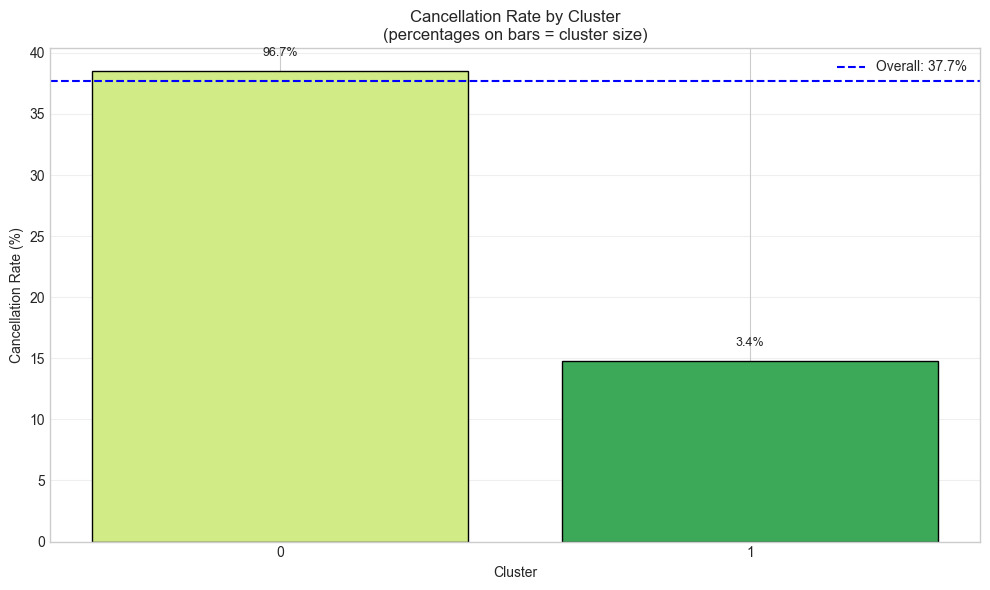

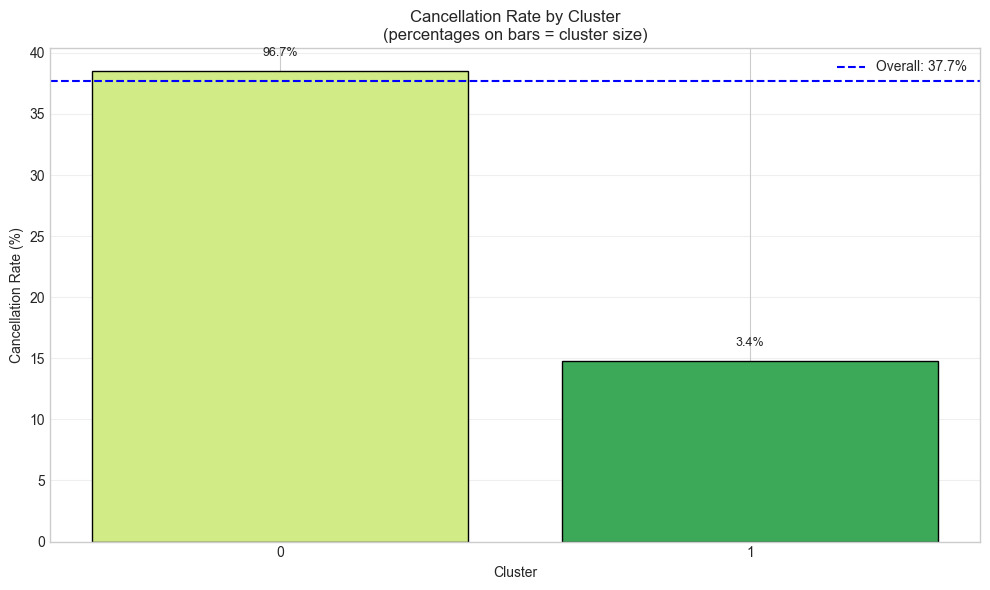

In [32]:
# Plot cancellation rate by cluster
plot_cancellation_by_cluster(
    profiles_kmeans,
    figsize=(10, 6),
    save_path=str(FIGURES_DIR / 'kmeans_cancellation_by_cluster.png')
)

✓ Saved figure to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\kmeans_cluster_profiles.png


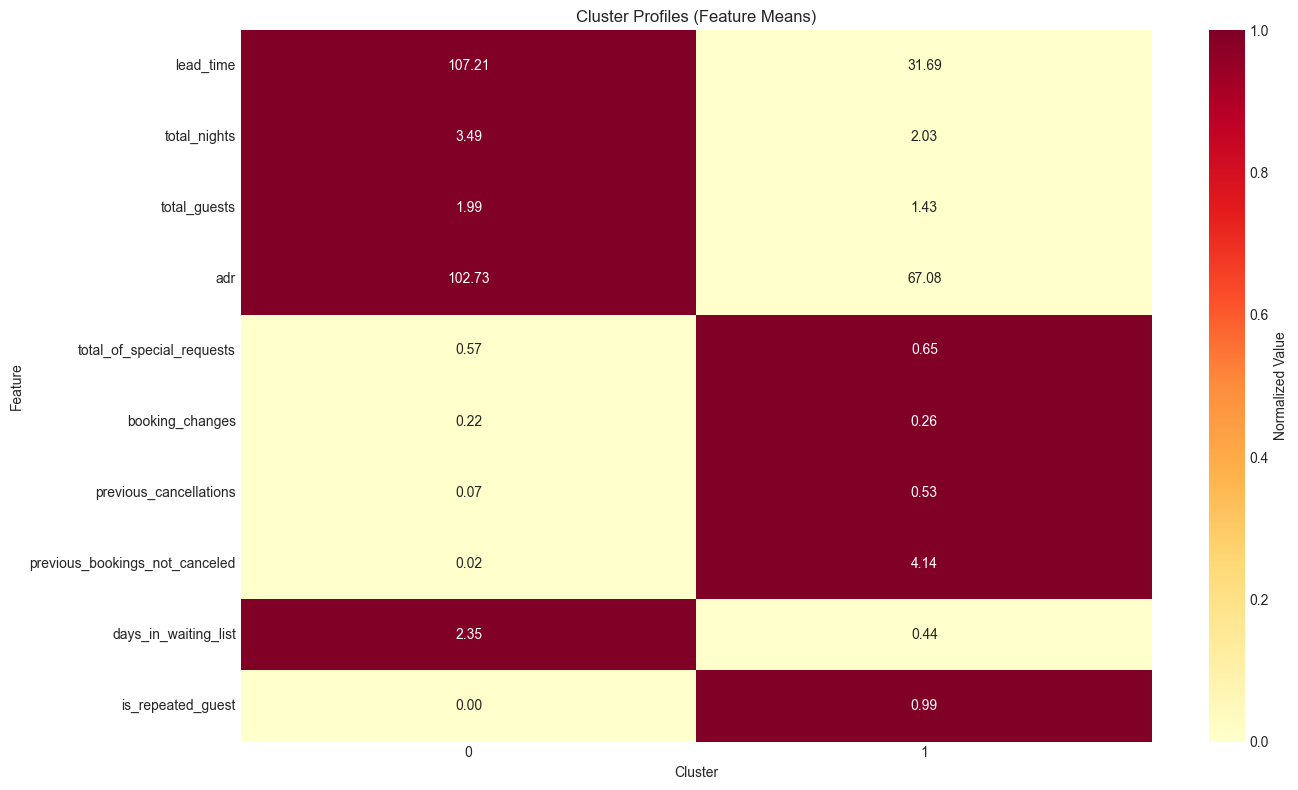

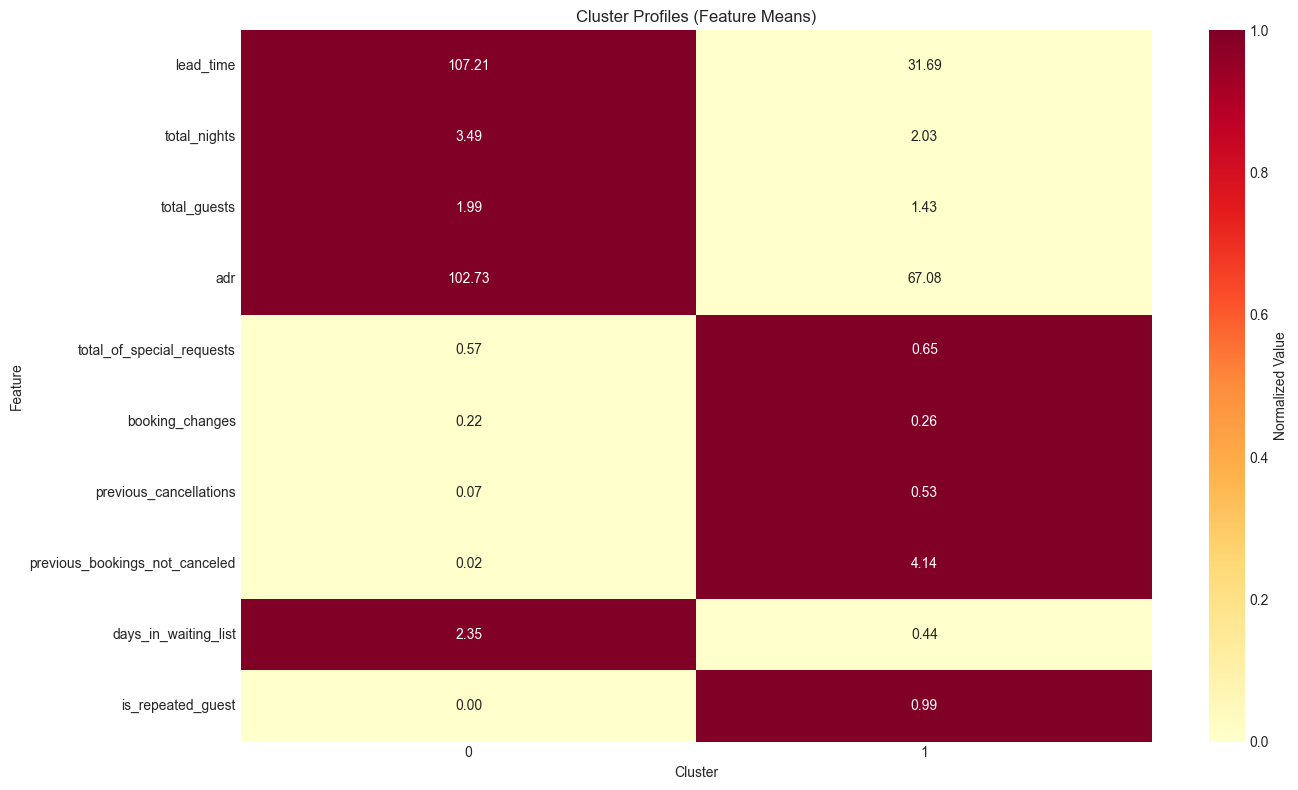

In [33]:
# Plot cluster profiles heatmap
plot_cluster_profiles(
    profiles_kmeans,
    features=feature_names,
    figsize=(14, 8),
    save_path=str(FIGURES_DIR / 'kmeans_cluster_profiles.png')
)

## 14. Hierarchical Clustering

In [34]:
# Run Hierarchical clustering with same k
labels_hc, hc_model = run_hierarchical(
    X_sample,
    n_clusters=optimal_k,
    linkage='ward',
    verbose=True
)

RUNNING HIERARCHICAL CLUSTERING (k=2, linkage=ward)



Cluster sizes:
  Cluster 0: 686 (3.4%)
  Cluster 1: 19,314 (96.6%)


In [35]:
# Evaluate hierarchical clustering
metrics_hc = evaluate_clustering(X_sample, labels_hc, verbose=True)

CLUSTERING EVALUATION METRICS
Number of clusters: 2
Silhouette Score: 0.6184 (higher is better, -1 to 1)
Davies-Bouldin Index: 1.1194 (lower is better)
Calinski-Harabasz Index: 3076.83 (higher is better)


✓ Saved figure to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\hierarchical_clusters_pca.png


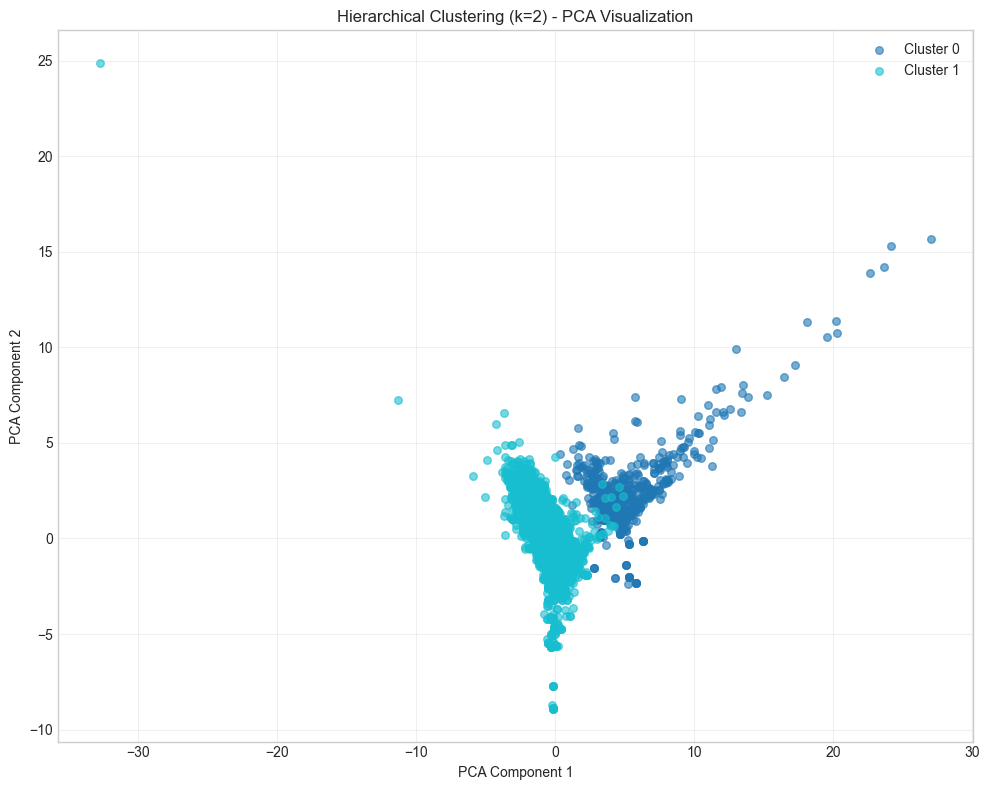

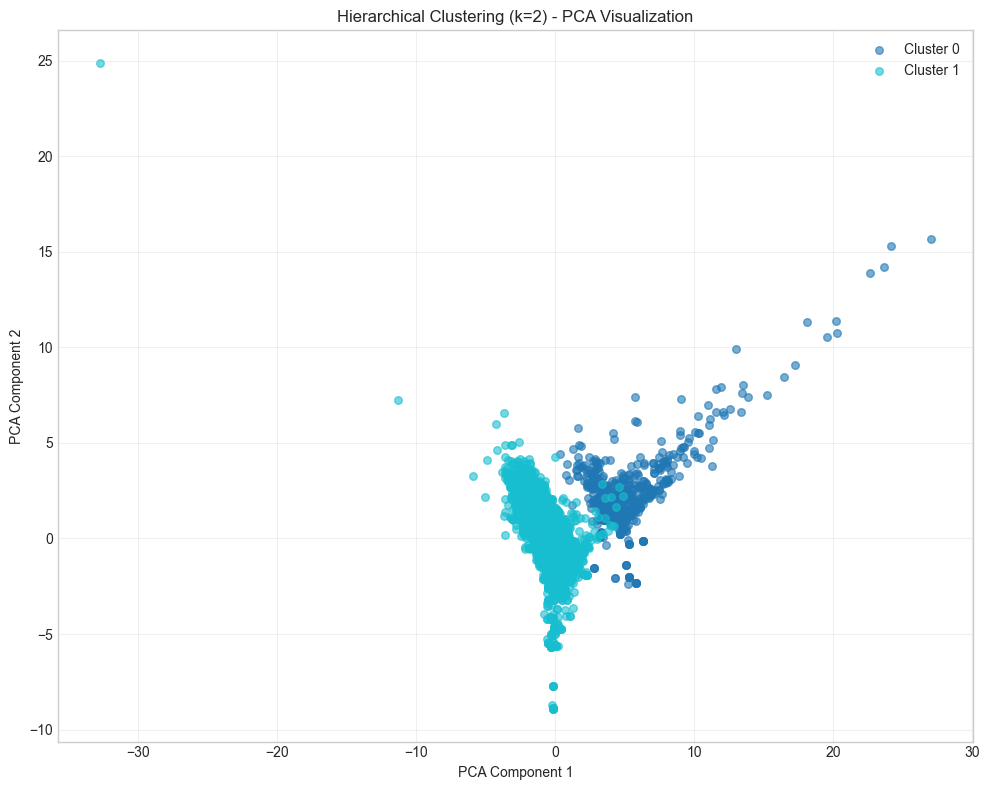

In [36]:
# Visualize hierarchical clusters
plot_clusters_2d(
    X_sample,
    labels_hc,
    method='pca',
    title=f'Hierarchical Clustering (k={optimal_k}) - PCA Visualization',
    figsize=(10, 8),
    save_path=str(FIGURES_DIR / 'hierarchical_clusters_pca.png')
)

## 15. DBSCAN Clustering

In [37]:
# DBSCAN - density-based clustering
# Note: DBSCAN doesn't require k, but needs eps and min_samples
labels_dbscan, dbscan_model = run_dbscan(
    X_sample,
    eps=1.5,  # May need tuning
    min_samples=50,
    verbose=True
)

RUNNING DBSCAN (eps=1.5, min_samples=50)


Number of clusters: 4
Noise points: 1,313 (6.6%)

Cluster sizes:
  Noise: 1,313 (6.6%)
  Cluster 0: 16,135 (80.7%)
  Cluster 1: 1,765 (8.8%)
  Cluster 2: 456 (2.3%)
  Cluster 3: 331 (1.7%)


In [38]:
# Evaluate DBSCAN (if more than 1 cluster)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
if n_clusters_dbscan >= 2:
    metrics_dbscan = evaluate_clustering(X_sample, labels_dbscan, verbose=True)
else:
    print("⚠️ DBSCAN found less than 2 clusters, try different parameters")

CLUSTERING EVALUATION METRICS
Number of clusters: 4
Silhouette Score: 0.1551 (higher is better, -1 to 1)
Davies-Bouldin Index: 1.9948 (lower is better)
Calinski-Harabasz Index: 1489.34 (higher is better)


## 16. Compare Clustering Methods

In [39]:
# Compare clustering methods
comparison_df = pd.DataFrame({
    'Method': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'n_clusters': [
        metrics_kmeans.get('n_clusters', 'N/A'),
        metrics_hc.get('n_clusters', 'N/A'),
        n_clusters_dbscan if n_clusters_dbscan >= 2 else 'N/A'
    ],
    'Silhouette': [
        metrics_kmeans.get('silhouette_score', 'N/A'),
        metrics_hc.get('silhouette_score', 'N/A'),
        metrics_dbscan.get('silhouette_score', 'N/A') if n_clusters_dbscan >= 2 else 'N/A'
    ],
    'Davies-Bouldin': [
        metrics_kmeans.get('davies_bouldin_score', 'N/A'),
        metrics_hc.get('davies_bouldin_score', 'N/A'),
        metrics_dbscan.get('davies_bouldin_score', 'N/A') if n_clusters_dbscan >= 2 else 'N/A'
    ],
    'Calinski-Harabasz': [
        metrics_kmeans.get('calinski_harabasz_score', 'N/A'),
        metrics_hc.get('calinski_harabasz_score', 'N/A'),
        metrics_dbscan.get('calinski_harabasz_score', 'N/A') if n_clusters_dbscan >= 2 else 'N/A'
    ]
})

print("\n" + "="*80)
print("📊 CLUSTERING METHODS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n✅ Best Silhouette: Higher is better (range: -1 to 1)")
print("✅ Best Davies-Bouldin: Lower is better")
print("✅ Best Calinski-Harabasz: Higher is better")


📊 CLUSTERING METHODS COMPARISON
      Method  n_clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz
      KMeans           2    0.595197        0.992418        3059.258594
Hierarchical           2    0.618387        1.119415        3076.830254
      DBSCAN           4    0.155129        1.994838        1489.342892

✅ Best Silhouette: Higher is better (range: -1 to 1)
✅ Best Davies-Bouldin: Lower is better
✅ Best Calinski-Harabasz: Higher is better


## 17. Detailed Cluster Analysis (Best Method)

In [40]:
# Use KMeans as the primary method (usually performs well)
# Detailed analysis of each cluster

print("\n" + "="*80)
print("🔍 DETAILED CLUSTER ANALYSIS (KMEANS)")
print("="*80)

# Add cluster labels to sample data
df_sample_clustered = df_sample.copy()
df_sample_clustered['cluster'] = labels_kmeans

for cluster in sorted(df_sample_clustered['cluster'].unique()):
    cluster_data = df_sample_clustered[df_sample_clustered['cluster'] == cluster]
    
    print(f"\n\n{'='*60}")
    print(f"📊 CLUSTER {cluster}")
    print(f"{'='*60}")
    
    # Size
    size = len(cluster_data)
    pct = size / len(df_sample_clustered) * 100
    print(f"\n📈 Size: {size:,} bookings ({pct:.1f}%)")
    
    # Cancellation rate
    cancel_rate = cluster_data['is_canceled'].mean() * 100
    print(f"❌ Cancellation Rate: {cancel_rate:.1f}%")
    
    # Key characteristics
    print(f"\n📋 Key Characteristics:")
    for feat in feature_names:
        if feat in cluster_data.columns:
            mean_val = cluster_data[feat].mean()
            median_val = cluster_data[feat].median()
            overall_mean = df_sample_clustered[feat].mean()
            diff = ((mean_val - overall_mean) / overall_mean * 100) if overall_mean != 0 else 0
            
            direction = "↑" if diff > 10 else "↓" if diff < -10 else "→"
            print(f"   {feat}: mean={mean_val:.2f} ({direction} {abs(diff):.0f}% vs overall)")


🔍 DETAILED CLUSTER ANALYSIS (KMEANS)


📊 CLUSTER 0

📈 Size: 19,330 bookings (96.7%)
❌ Cancellation Rate: 38.5%

📋 Key Characteristics:
   lead_time: mean=107.21 (→ 2% vs overall)
   total_nights: mean=3.49 (→ 1% vs overall)
   total_guests: mean=1.99 (→ 1% vs overall)
   adr: mean=102.73 (→ 1% vs overall)
   total_of_special_requests: mean=0.57 (→ 0% vs overall)
   booking_changes: mean=0.22 (→ 1% vs overall)
   previous_cancellations: mean=0.07 (↓ 17% vs overall)
   previous_bookings_not_canceled: mean=0.02 (↓ 90% vs overall)
   days_in_waiting_list: mean=2.35 (→ 3% vs overall)
   is_repeated_guest: mean=0.00 (↓ 100% vs overall)


📊 CLUSTER 1

📈 Size: 670 bookings (3.4%)
❌ Cancellation Rate: 14.8%

📋 Key Characteristics:
   lead_time: mean=31.69 (↓ 70% vs overall)
   total_nights: mean=2.03 (↓ 41% vs overall)
   total_guests: mean=1.43 (↓ 28% vs overall)
   adr: mean=67.08 (↓ 34% vs overall)
   total_of_special_requests: mean=0.65 (↑ 14% vs overall)
   booking_changes: mean=0.26 (↑ 1

## 18. Save Results

In [41]:
# Save cluster profiles
profiles_kmeans.to_csv(TABLES_DIR / 'cluster_profiles_kmeans.csv', index=False)
print(f"✅ Saved cluster profiles to {TABLES_DIR / 'cluster_profiles_kmeans.csv'}")

# Save comparison
comparison_df.to_csv(TABLES_DIR / 'clustering_comparison.csv', index=False)
print(f"✅ Saved clustering comparison to {TABLES_DIR / 'clustering_comparison.csv'}")

✅ Saved cluster profiles to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\tables\cluster_profiles_kmeans.csv
✅ Saved clustering comparison to C:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\tables\clustering_comparison.csv


---

## 19. Summary & Key Findings

In [42]:
print("\n" + "="*80)
print("📝 SUMMARY OF DATA MINING ANALYSIS")
print("="*80)

print("\n" + "-"*40)
print("PART A: ASSOCIATION RULES")
print("-"*40)
if MLXTEND_AVAILABLE and 'rules' in dir() and rules is not None:
    print(f"✅ Total rules found: {len(rules)}")
    if 'cancel_rules' in dir() and cancel_rules is not None:
        print(f"✅ Rules predicting cancellation: {len(cancel_rules)}")
        print(f"\n🔑 Key factors leading to cancellation:")
        # Extract top antecedents
        if len(cancel_rules) > 0:
            top_rules = cancel_rules.nlargest(5, 'lift')
            for _, rule in top_rules.iterrows():
                print(f"   - {', '.join(list(rule['antecedents']))}")
else:
    print("⚠️ Association rules not computed (mlxtend not available)")

print("\n" + "-"*40)
print("PART B: CUSTOMER CLUSTERING")
print("-"*40)
print(f"✅ Optimal number of clusters: {optimal_k}")
print(f"✅ Best silhouette score (KMeans): {metrics_kmeans['silhouette_score']:.4f}")
print(f"\n🚨 High-risk clusters (cancel rate > 50%): {high_risk_clusters}")

print("\n" + "-"*40)
print("BUSINESS INSIGHTS")
print("-"*40)
print("\n1. Association Rules can identify booking patterns that lead to cancellation")
print("2. Customer segmentation reveals distinct groups with varying cancellation risks")
print("3. High-risk clusters can be targeted with retention strategies")
print("4. These insights can be used to:")
print("   - Implement dynamic pricing for high-risk segments")
print("   - Offer incentives to reduce cancellations")
print("   - Improve overbooking strategies")

print("\n" + "="*80)
print("✅ MINING & CLUSTERING ANALYSIS COMPLETE!")
print("="*80)


📝 SUMMARY OF DATA MINING ANALYSIS

----------------------------------------
PART A: ASSOCIATION RULES
----------------------------------------
✅ Total rules found: 95411
✅ Rules predicting cancellation: 5749

🔑 Key factors leading to cancellation:
   - deposit_type=Non Refund, meal=BB, distribution_channel=TA/TO, is_repeated_guest=NewGuest
   - deposit_type=Non Refund, is_repeated_guest=NewGuest, total_of_special_requests=0_req, meal=BB, distribution_channel=TA/TO
   - deposit_type=Non Refund, meal=BB, distribution_channel=TA/TO, is_repeated_guest=NewGuest
   - deposit_type=Non Refund, meal=BB, distribution_channel=TA/TO
   - deposit_type=Non Refund, meal=BB, distribution_channel=TA/TO

----------------------------------------
PART B: CUSTOMER CLUSTERING
----------------------------------------
✅ Optimal number of clusters: 2
✅ Best silhouette score (KMeans): 0.5952

🚨 High-risk clusters (cancel rate > 50%): []

----------------------------------------
BUSINESS INSIGHTS
--------------